In [1]:
import os, sys, json
import numpy as np
import pandas as pd
import itertools as it

from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession
from sklearn.decomposition import FastICA

import matplotlib.pyplot as plt

SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def make_stim_prs_table(session, stim_name):
    
    my_dict = session.get_parameter_values_for_stimulus(stim_name)
    
    allNames = sorted(my_dict)
    
    if stim_name == 'static_gratings':
        allNames = ['orientation','spatial_frequency','phase']
        #allNames = ['spatial_frequency','orientation','phase']
    elif stim_name == 'drifting_gratings':
        allNames = ['orientation','temporal_frequency']
    elif stim_name == 'flashes':
        allNames=['color']
    elif 'natural_movie' in stim_name:
        allNames = ['frame']
    
    combinations = it.product(*(my_dict[Name] for Name in allNames))
    
    stim_prs_df = pd.DataFrame((list(combinations)), columns=allNames)
    stim_cond_df = session.stimulus_conditions[session.stimulus_conditions.stimulus_name == stim_name]
    n_stimc = stim_cond_df.shape[0]
    n_stim_prs = stim_prs_df.shape[1]
    if len(stim_prs_df) < n_stimc:
        stim_prs_df.loc[len(stim_prs_df)] = n_stim_prs*['null']

    return allNames, stim_prs_df

In [3]:
def gauss(sigma,dt):
    x = dt*np.arange(-np.ceil(4*sigma/dt),np.ceil(4*sigma/dt))
    gfil = dt/(sigma*np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2))
    gfil = gfil/np.sum(gfil)
    
    return gfil

In [4]:
def get_stim_pres_ids_for_given_stimulus_condition_id(stim_table, stim_cond_id):
    
    spids = stim_table[stim_table.stimulus_condition_id==stim_cond_id].index.values
    
    return spids

In [47]:
def get_layers_df(experiment_id, layers_dir, units_df, cstr):
    #layers_dir = '/Users/Ram/Dropbox/VC_NP_sklearn_copy/layer_est_from_Jung/'
    visp_units = units_df[units_df.ecephys_structure_acronym == cstr].index.values
    lyr_fname = os.path.join(layers_dir,experiment_id+'_layer.json')
    try:
        with open(lyr_fname) as datafile:
            data = json.load(datafile)
            
        lyr_df = pd.DataFrame(data.items(), index = data.keys())
        cstr_lyr = lyr_df.loc[list(units_df[units_df.ecephys_structure_acronym ==cstr].peak_channel_id.values.astype(str))]
        cstr_lyr.columns = ['peak_channel_id','layer']
        cstr_lyr['unit_id'] = visp_units
    except Exception as e:
        print(e)
        cstr_lyr = pd.DataFrame()
        cstr_lyr['unit_id'] = visp_units
        cstr_lyr['layer'] = 0
        
    return cstr_lyr


In [6]:
def get_unit_ids_in_given_cstr_layer(cstr_layer_df, lyr = None):
    
    if lyr in [2, 4, 5, 6]:
        units_in_cstr_lyr = cstr_lyr_df[cstr_lyr_df.layer == lyr]['unit_id'].values
    else:
        units_in_cstr_lyr = cstr_lyr_df['unit_id'].values
    return units_in_cstr_lyr

In [7]:
def calc_pop_trial_avg_fr_for_given_sg_cond_and_units\
(session, stim_pres_ids, units_of_interest, bin_edges_full = np.arange(0.0,0.25,0.001)):
    
    tmp_binned_spt = session.presentationwise_spike_counts\
    (bin_edges = bin_edges_full, stimulus_presentation_ids = stim_pres_ids, unit_ids = units_of_interest)
    
    return tmp_binned_spt

In [8]:
def get_smoothed_fr_arr(binned_spt, dt = 0.001, sig = 0.001):
    
    filt = gauss(sig,dt)

    fr_arr = np.zeros((binned_spt.shape[1],binned_spt.shape[2]))
    fr_sm_arr = np.zeros((binned_spt.shape[1], binned_spt.shape[2]))
    
    for cnum in range(binned_spt.shape[2]):
        fr_arr[:,cnum] = np.mean(binned_spt[:,:,cnum],axis=0)/dt
        fr_sm_arr[:,cnum] = np.convolve(fr_arr[:,cnum],filt,'same')
    
    return fr_sm_arr

In [9]:
expt_id = '715093703'
nwb_path = '/Users/Ram/Desktop/ecephys_session_' + expt_id + '.nwb'
#nwb_path = '/Users/Ram/Dropbox/VC_NP_sklearn_copy/ecephys_session_' + expt_id + '.nwb'
#nwb_path = '/Users/Ram/Dropbox/VC_NP_sklearn_copy/ecephys_session_' + expt_id + '.nwb'

session = EcephysSession.from_nwb_path(nwb_path, api_kwargs={
        "amplitude_cutoff_maximum": 0.1,
        "presence_ratio_minimum": 0.9,
        "isi_violations_maximum": 0.5
    })

In [123]:
dt = 0.001
sig = 0.005
stim_name = 'natural_scenes'#'static_gratings'#'natural_movie_one'#'drifting_gratings',#'flashes' #'natural_scenes'#'static_gratings' 

col_names, stim_prs_df = make_stim_prs_table(session, stim_name)
print(col_names)
stim_prs_df.head()

['frame']


,frame
0,-1.0
1,0.0
2,1.0
3,2.0
4,3.0


In [124]:
stim_table = session.get_stimulus_table(stim_name)
    
stim_durn = int(1000.*np.mean(stim_table.duration.values))/1000
bef = np.arange(0.0,stim_durn, dt)
print(stim_durn,len(bef))

scid = np.unique(stim_table.stimulus_condition_id.values)
#null_scid = stim_table[stim_table[col_names[0]]=='null'].stimulus_condition_id.values[0]

0.25 250


In [125]:
fr_pop_avg_for_units_of_interest = pd.DataFrame(index = range(len(scid)), columns = list(col_names) + list(range(len(bef)-1)))

In [126]:
cstr = 'LGd'#'VISp'
lyr = None#6

layers_dir = '/Users/Ram/Dropbox/VC_NP_sklearn_copy/layer_est_from_Jung/'
cstr_lyr_df = get_layers_df(expt_id, layers_dir, session.units, cstr)
cstr_lyr_df.head()

,peak_channel_id,layer,unit_id
850259947,850259947,0,950934765
850259957,850259957,0,950934843
850259955,850259955,0,950934728
850259965,850259965,0,950934971
850259967,850259967,0,950934992


In [127]:
if np.unique(cstr_lyr_df.layer)[0] == 0:
    units_of_interest = get_unit_ids_in_given_cstr_layer(cstr_lyr_df, lyr = None)
else :
    units_of_interest = get_unit_ids_in_given_cstr_layer(cstr_lyr_df, lyr = lyr)

In [128]:
for jj, stim_cond_id in enumerate(scid):
    
    fr_pop_avg_for_units_of_interest.iloc[jj][col_names] = \
            stim_table[stim_table.stimulus_condition_id==stim_cond_id][col_names].values[0]
    
    stim_pres_ids = get_stim_pres_ids_for_given_stimulus_condition_id(stim_table, stim_cond_id)
    
    tmp_binned_spt = calc_pop_trial_avg_fr_for_given_sg_cond_and_units\
(session, stim_pres_ids, units_of_interest, bin_edges_full = bef)
    
    sm_fr_arr = get_smoothed_fr_arr(tmp_binned_spt, dt = dt, sig = sig)
    
    fr_pop_avg_for_units_of_interest.iloc[jj,len(col_names):] = np.nanmean(sm_fr_arr,axis = 1)

In [129]:
fr_arr = fr_pop_avg_for_units_of_interest.iloc[:,len(col_names):].values.astype(float)

sorted_df = pd.merge(stim_prs_df,fr_pop_avg_for_units_of_interest, on=list(col_names))
fr_arr_sorted = sorted_df.iloc[:,len(col_names):].values.astype(float)

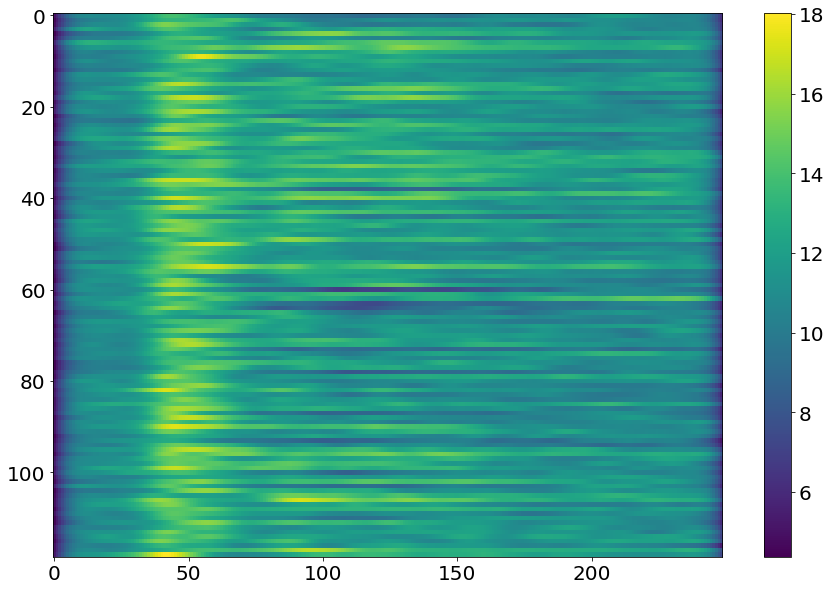

In [130]:
fig,ax = plt.subplots(1,1,figsize = (15,10),sharex=True)

im = ax.imshow(fr_arr_sorted, aspect='auto')
if 'gratings' in stim_name:
    yv = np.where(np.diff(stim_prs_df.orientation.values[:-1].astype(float)))[0] + 0.5
    ax.hlines(yv, 0, 1, transform=ax.get_yaxis_transform(), color='k')

plt.colorbar(im)
plt.show()

In [ ]:
fig,ax = plt.subplots(3,1,figsize = (20,40),sharex=True)

ax[0].imshow(fr_arr ,aspect='auto')

ax[1].imshow(fr_arr_sorted, aspect='auto')
if 'gratings' in stim_name:
    yv = np.where(np.diff(stim_prs_df.orientation.values[:-1].astype(float)))[0] + 0.5
    ax[1].hlines(yv, 0, 1, transform=ax[1].get_yaxis_transform(), color='k')

ax[2].plot(np.mean(fr_arr_sorted[:,:],axis=0))

plt.show()

(249, 2)
(249, 6)


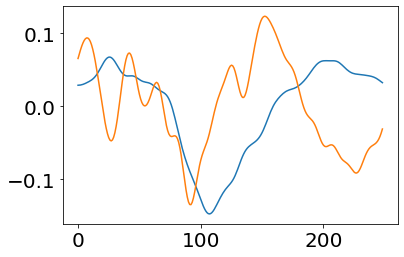

In [26]:
#X_raw = fr_arr_sorted - fr_arr_sorted[-1,:]
#X = X_raw[:-1,:].T

#for one stimulus condition
sc = [19, 39, 59, 79, 99, 119]
X_raw = fr_arr_sorted[sc,:] - fr_arr_sorted[-1,:]
X = X_raw.T

from sklearn.decomposition import FastICA
ica = FastICA(n_components=2, random_state=0, whiten=True)
X_ = ica.fit_transform(X)
print(X_.shape)
A_ = ica.mixing_
#print(transformer.mixing_)
X_rec = np.dot(X_, A_.T) + ica.mean_
print(X_rec.shape)

plt.figure()
plt.plot(X_)
plt.show()

In [27]:
sc = 35
plt.figure()
plt.plot(X[:,sc])
plt.plot(X_rec[:,sc])
#plt.plot(fr_arr_sorted[sc,:])
plt.show()

IndexError: index 35 is out of bounds for axis 1 with size 6

<Figure size 432x288 with 0 Axes>